In [1]:
# Required to correctly display interactive (dynamic) plots in Jupyter notebooks.
# This code cell must be run before any other code cell.
%matplotlib notebook

# Imports
from skmultiflow.data import FileStream
from skmultiflow.data import SEAGenerator
from skmultiflow.evaluation import EvaluatePrequential
from skmultiflow.bayes import NaiveBayes
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.trees import HoeffdingAdaptiveTreeClassifier
from skmultiflow.drift_detection import ADWIN

from sklearn.linear_model import SGDClassifier

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec


# scikit-multiflow demo

In this notebook, we show how to easily setup and run experiments in `scikit-multiflow`.

The demo is divided into the following parts:

1. Running a classification task
  1. Prequential evaluation implementation
  2. The `EvaluatePrequential` class

2. Concept drift detection
  1. Drift detection test
  2. Impact on predictive performance
  
---

---
## 1. Running a classification task

In this example we will use the `SEA` stream generator. A data generator does not store any data, but generates it on demand.

Next we will setup a learning method (model, estimator, algorithm), in this case the Naive Bayes classifier:

In [2]:
stream = SEAGenerator(random_state=1)
classifier = NaiveBayes()

### Prequential evaluation

The prequentail evaluation is easily implemented as a loop:

In [3]:
# Variables to control evaluation loop and track performance
n_samples = 0
correct_cnt = 0
max_samples = 2000

# Prequential evaluation loop
while n_samples < max_samples and stream.has_more_samples():
   X, y = stream.next_sample()      # Get one sample from the stream
   y_pred = classifier.predict(X)   # Predict class for new data
   if y[0] == y_pred[0]:
       correct_cnt += 1
   classifier.partial_fit(X, y)     # Incrementally train the model with the new data
   n_samples += 1

print('{} samples analyzed.'.format(n_samples))   
print('NaiveBayes classifier accuracy: {}'.format(correct_cnt / n_samples))

2000 samples analyzed.
NaiveBayes classifier accuracy: 0.9395


### `EvaluatePrequential` class

Implements the prequential evaluation method and provides extra functionalities.

Let's run the same experiment on the SEA data but this time we will compare two classifiers:

1. `NaiveBayes`
2. `SGDClassifier`: Linear SVM with SGD training.

We choose the `SGDClassifier` in order to demonstrate the compatibility with incremental methods from `scikit-learn`. [6]

**Note:** `scikit-learn` focuses on the batch learing setting and only a **limited** number of its methods are capable to learn incrementally.

In [4]:
# Setup stream and estimators
stream = SEAGenerator(random_state=1)
nb = HoeffdingAdaptiveTreeClassifier()
svm = SGDClassifier()

# Setup evaluator
eval = EvaluatePrequential(show_plot=True,
                           max_samples=20000,
                           metrics=['kappa', 'running_time', 'model_size','f1'])

<IPython.core.display.Javascript object>


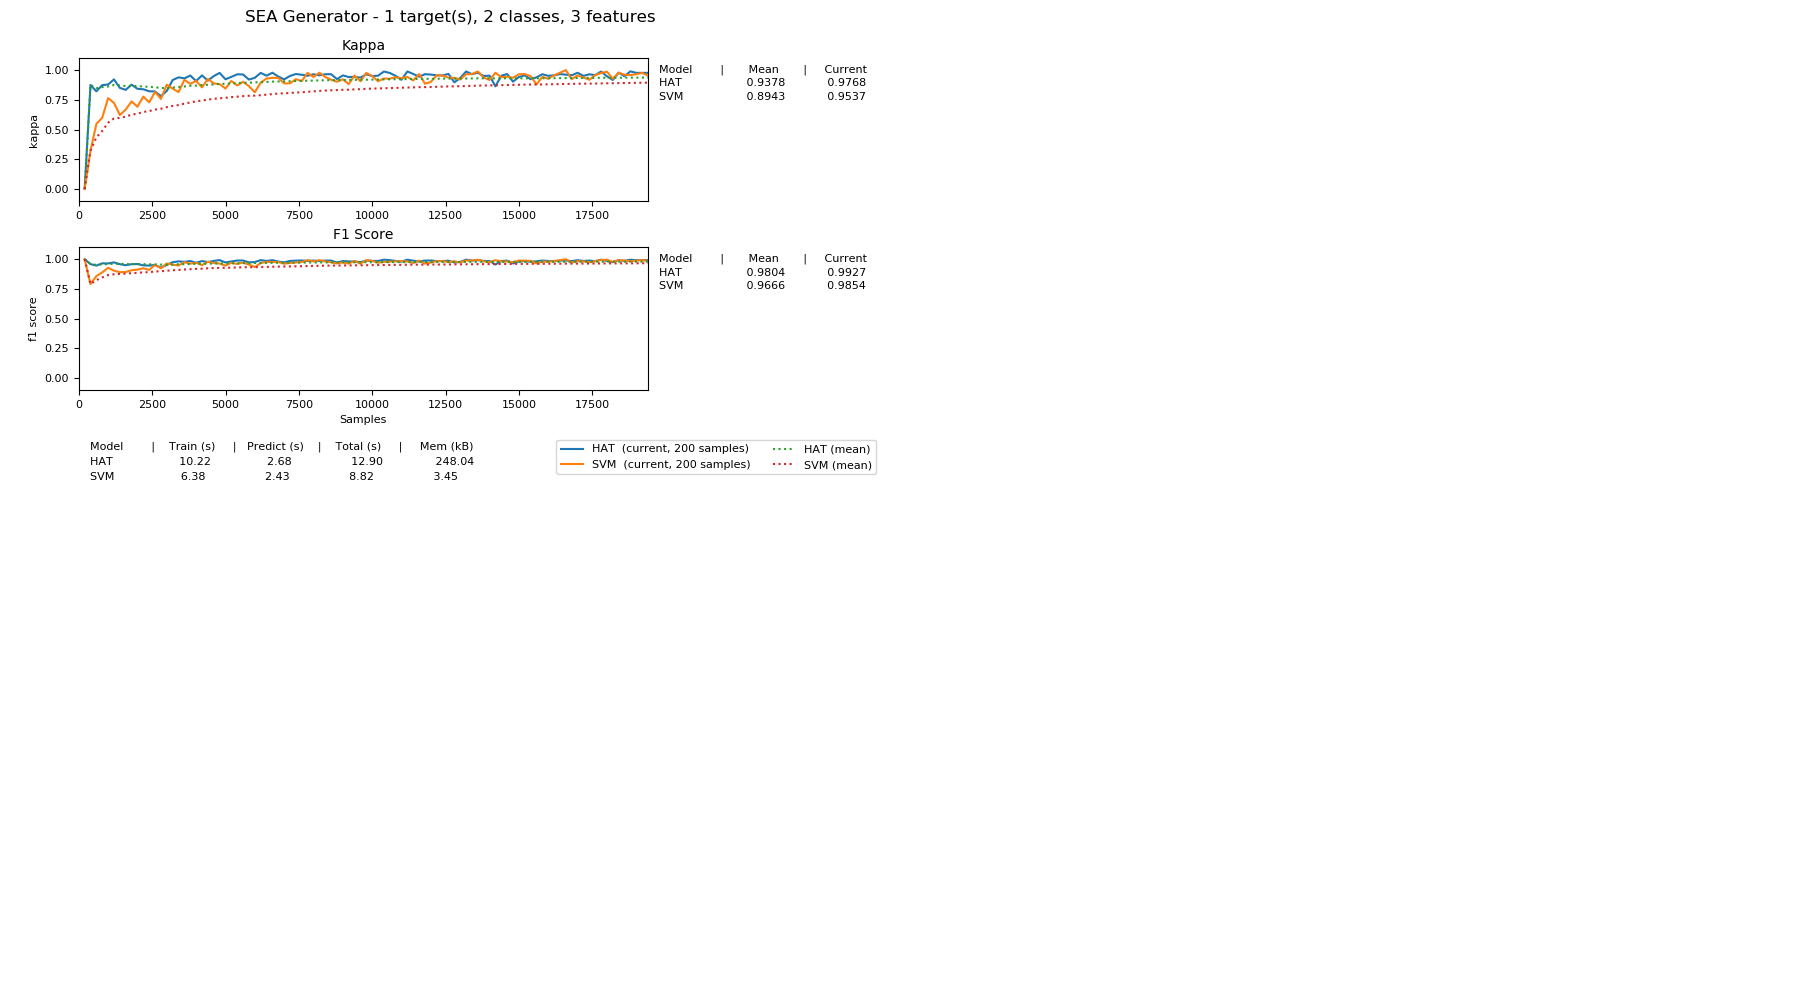

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [27.78s]
Processed samples: 20000
Mean performance:
HAT - Kappa        : 0.9389
HAT - F1 score: 0.9808
HAT - Training time (s)  : 10.55
HAT - Testing time  (s)  : 2.75
HAT - Total time    (s)  : 13.30
HAT - Size (kB)          : 252.7705
SVM - Kappa        : 0.8967
SVM - F1 score: 0.9673
SVM - Training time (s)  : 6.57
SVM - Testing time  (s)  : 2.50
SVM - Total time    (s)  : 9.07
SVM - Size (kB)          : 3.4453


In [5]:
# Run the evaluation
eval.evaluate(stream=stream, model=[nb, svm], model_names=['HAT', 'SVM']);

<IPython.core.display.Javascript object>


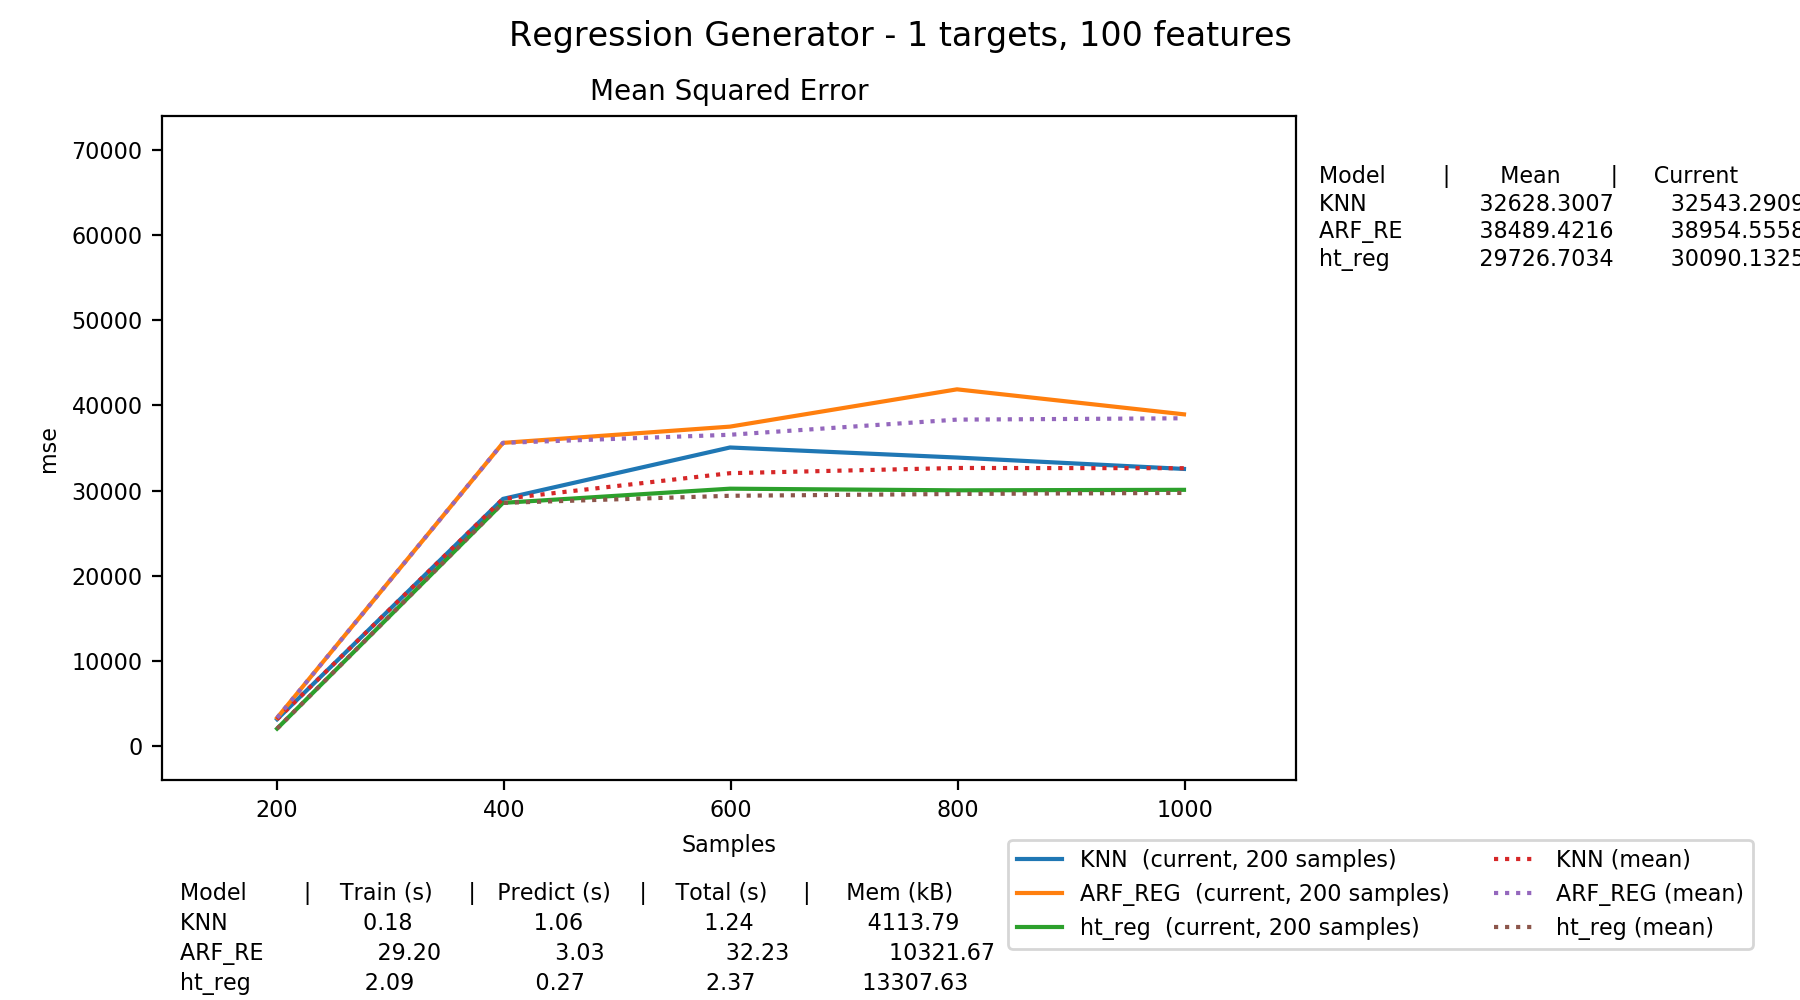

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #################### [100%] [37.59s]
Processed samples: 1000
Mean performance:
KNN - MSE          : 32628.3007
KNN - Training time (s)  : 0.18
KNN - Testing time  (s)  : 1.06
KNN - Total time    (s)  : 1.24
KNN - Size (kB)          : 4113.7891
ARF_REG - MSE          : 38489.4216
ARF_REG - Training time (s)  : 29.20
ARF_REG - Testing time  (s)  : 3.03
ARF_REG - Total time    (s)  : 32.23
ARF_REG - Size (kB)          : 10321.6670
ht_reg - MSE          : 29726.7034
ht_reg - Training time (s)  : 2.09
ht_reg - Testing time  (s)  : 0.27
ht_reg - Total time    (s)  : 2.37
ht_reg - Size (kB)          : 13307.6348


In [14]:
# Imports
from skmultiflow.data import RegressionGenerator
from skmultiflow.lazy import KNNRegressor
from skmultiflow.meta import AdaptiveRandomForestRegressor
from skmultiflow.trees import HoeffdingTreeRegressor
import numpy as np


# Setup the data stream
stream = RegressionGenerator(random_state=1)
# Setup the estimator
knn = KNNRegressor()
arf_reg = AdaptiveRandomForestRegressor(random_state=123456)
ht_reg = HoeffdingTreeRegressor()
# Auxiliary variables to control loop and track performance
'''n_samples = 0
correct_cnt = 0
max_samples = 2000
y_pred = np.zeros(max_samples)
y_true = np.zeros(max_samples)

y_pred_arf = np.zeros(max_samples)
y_true_arf = np.zeros(max_samples)

# Run test-then-train loop for max_samples or while there is data in the stream
while n_samples < max_samples and stream.has_more_samples():
    X, y = stream.next_sample()
    y_true[n_samples] = y[0]
    y_true_arf[n_samples] = y[0]
    y_pred[n_samples] = knn.predict(X)[0]
    y_pred_arf[n_samples] = arf_reg.predict(X)[0]
    knn.partial_fit(X, y)
    arf_reg.partial_fit(X,y)
    n_samples += 1
    
# Display results
print('{} samples analyzed.'.format(n_samples))
print('KNN regressor mean absolute error: {}'.format(np.mean(np.abs(y_true - y_pred))))
print('Adaptive Random Forest regressor mean absolute error: {}'.format(np.mean(np.abs(y_true_arf - y_pred_arf))))
'''
eval = EvaluatePrequential(show_plot=True,
                           max_samples=1000,
                           metrics=['mean_square_error','model_size','running_time'])

eval.evaluate(stream=stream, model=[knn, arf_reg, ht_reg], model_names=['KNN', 'ARF_REG', 'ht_reg']);

---
## 2. Concept Drift

#### Simulate a data stream with concept drift

For this example, we will generate a synthetic data stream by concatenating 3 distributions of 1000 samples each:
- $dist_a$: $\mu=0.8$, $\sigma=0.05$
- $dist_b$: $\mu=0.4$, $\sigma=0.02$
- $dist_c$: $\mu=0.6$, $\sigma=0.1$.

In [7]:
random_state = np.random.RandomState(12345)
dist_a = random_state.normal(0.8, 0.05, 1000)
print(type(dist_a))
dist_b = random_state.normal(0.4, 0.02, 1000)
dist_c = random_state.normal(0.6, 0.1, 1000)

stream = np.concatenate((dist_a, dist_b, dist_c))
print(type(stream))

# Plot the data
fig = plt.figure(figsize=(7,3), tight_layout=True)
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1])
ax1.grid()
ax1.plot(stream, label='Stream')
ax2.grid(axis='y')
ax2.hist(dist_a, label=r'$dist_a$')
ax2.hist(dist_b, label=r'$dist_b$')
ax2.hist(dist_c, label=r'$dist_c$')
plt.legend()
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


<IPython.core.display.Javascript object>

### Drift detection test

In this example we will use the ADaptive WINdowing (`ADWIN`) drift detection method.

The goal is to detect that drift has occurred, after samples **1000** and **2000** in the synthetic data stream.

In [8]:
# Instantiate the ADWIN drift detector
drift_detector = ADWIN()

for i, val in enumerate(stream):
    drift_detector.add_element(val)        # Data is processed one sample at a time
    if drift_detector.detected_change():
        print('Change detected at index {}'.format(i))
        drift_detector.reset()

Change detected at index 1055
Change detected at index 2079


### Impact on predictive performance

In this example we will use two popular stream models:

1. The `Hoeffding Tree` is a type of decision tree designed for data streams.
2. The `Hoeffding Adaptive Tree` is an improvement over the original `Hoeffding Tree`.

The `Hoeffding Adaptive Tree` uses `ADWIN` to detect changes, if a change is detected at a given branch, an alternate branch is created and eventually replaces the original branch if it shows better performance on new data.

For this example we will load the data from a csv file using the `FileStream` class.

The data corresponds to the output of the `AGRAWALGenerator` with 3 **gradual drifts** at the 5k, 10k and 15k marks.

In [9]:
# Load data
#stream = FileStream("agr_a_20k.csv")
from skmultiflow.data import ConceptDriftStream
stream = ConceptDriftStream()
# Setup estimators
cfiers = [HoeffdingAdaptiveTreeClassifier(), SGDClassifier()]
# Setup evaluations
eval = EvaluatePrequential(show_plot=True,
                           metrics=['accuracy', 'kappa', 'model_size','f1'],
                           n_wait=100)

Run the evaluation

<IPython.core.display.Javascript object>


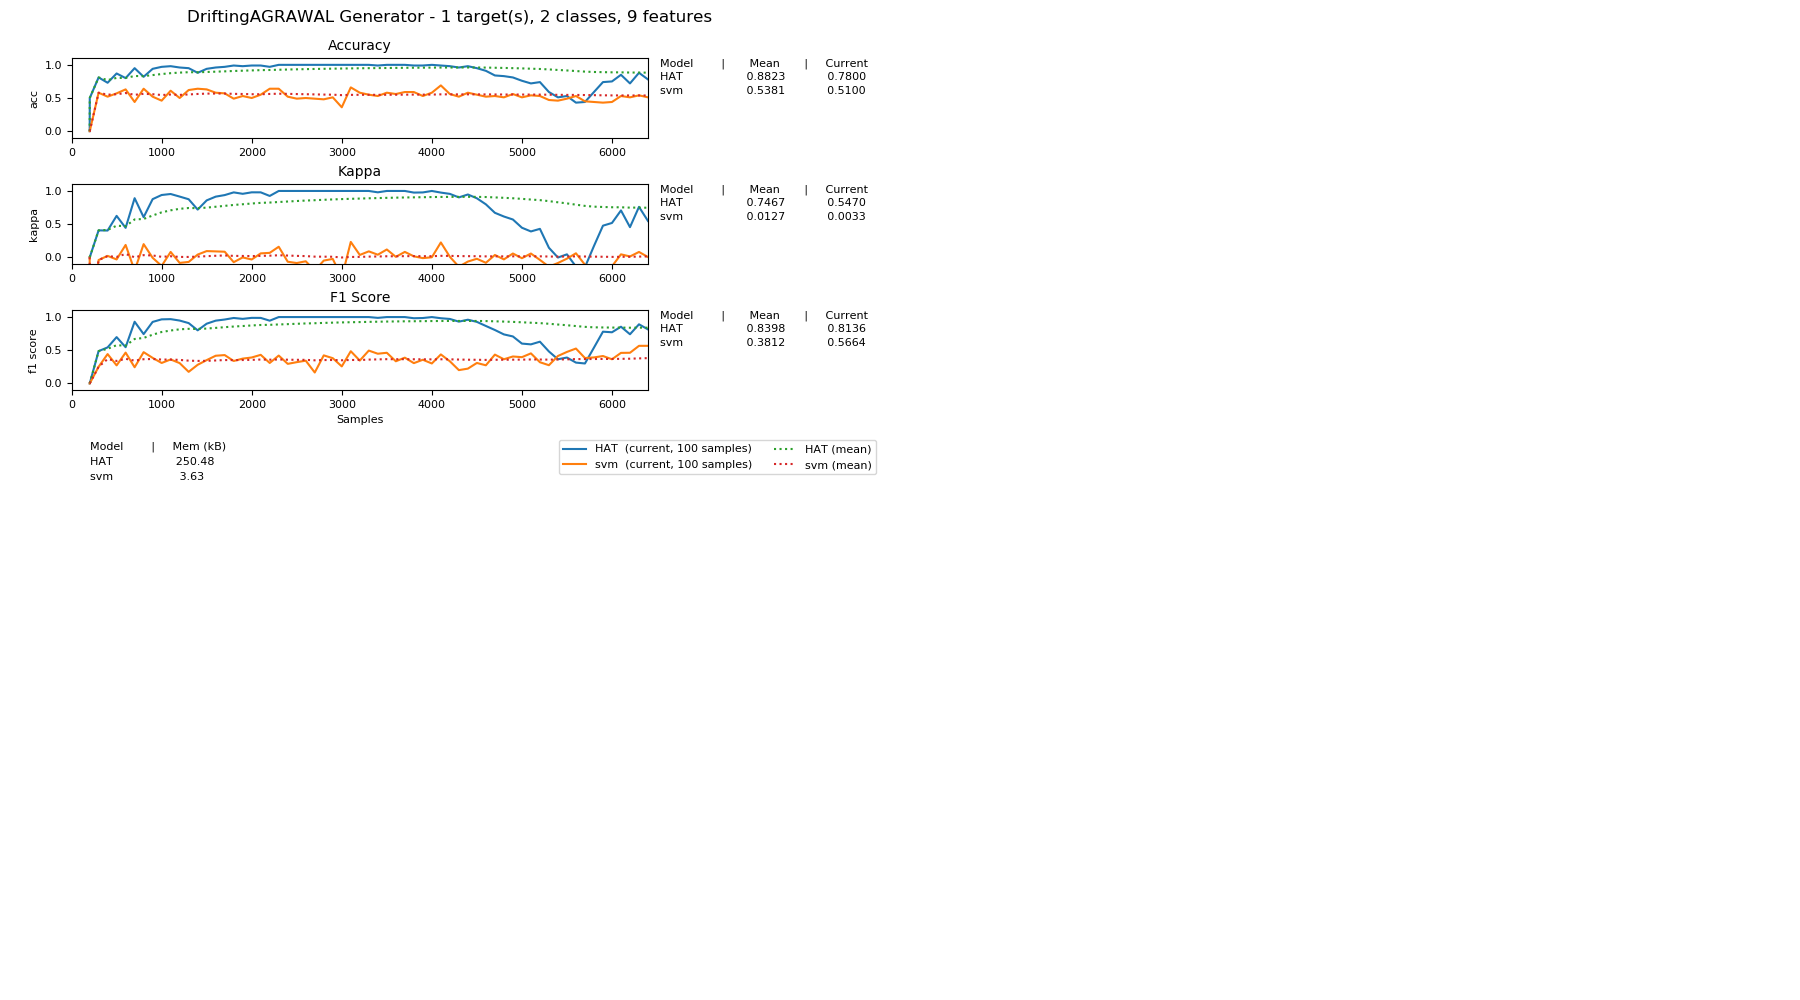

Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 200 sample(s).
Evaluating...
 #------------------- [5%] [7.12s]
Processed samples: 6500
Mean performance:
HAT - Accuracy     : 0.8811
HAT - Kappa        : 0.7449
HAT - F1 score: 0.8392


TypeError: 'NoneType' object is not subscriptable

In [10]:
eval.evaluate(stream=stream, model=cfiers, model_names=['HAT','svm']);